![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
Welcome to The QuantConnect Research Page!

Refer to this page for documentation https://www.quantconnect.com/docs#Introduction-to-Jupyter

Contribute to this template file https://github.com/QuantConnect/Research/tree/master/Notebooks

In [1]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
# Create an instance
qb = QuantBook()

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')

### <center> pairs trading </center>
Pairs trading is a market neutral trading strategy and it belongs to statistical arbitrage. The basic idea is to select two stocks which move similarly, sell high priced stock and buy low priced stock where there is a price divergence between the pairs.

### Cointegration
Before using pairs trading, we need to know the cointegration. Cointegration is a statistical property of time series (that is a series of random variables)

- Correlation specifies the co-movement of return, it is a short-term relationship

- Cointegration specifies co-movement of price, it is a long-term relationship

Generally speaking, the weak stationary process means the mean and the autocovariance do not vary from time. For example, white noise $\epsilon_t$ is an example of stationary time series because $E(\epsilon_t)=0$ and $Var(\epsilon_t)=\sigma^2$. 

If two series {$x_t$} and {$y_t$} are not stationary but their linear combination $ u_t = \beta x_t - y_t$ is a stationary process, then we say {xt} and {yt} are cointegrated. Here we take the first-order difference of x and y, then we say their relationship is first-order cointegration. Most of the financial time series are integrated into order 1.

In general, we use Augmented Dickey-Fuller test to test cointegration.

### Can we apply this idea to trading strategy?

The most widely used model of stock price is 
$$\frac{\text{d}S_t}{S_t}=\mu \text{d}t+\sigma \text{d}W_t$$
$S_t$ is stock price, $\mu$ is average return(drift term), $\sigma$ is volatility (variance term), $W_t$ is Brownian motion.
From ito's Lemma we get
$$\text{d} log(S_t)=(\mu-\frac{\sigma^2}{2}) \text{d}t + \sigma \text{d}W_t$$
So logarithm price is integrated into order 1.

### Step 1: Find two likely cointegrated stocks

Text(0,0.5,'Cumulative Return')

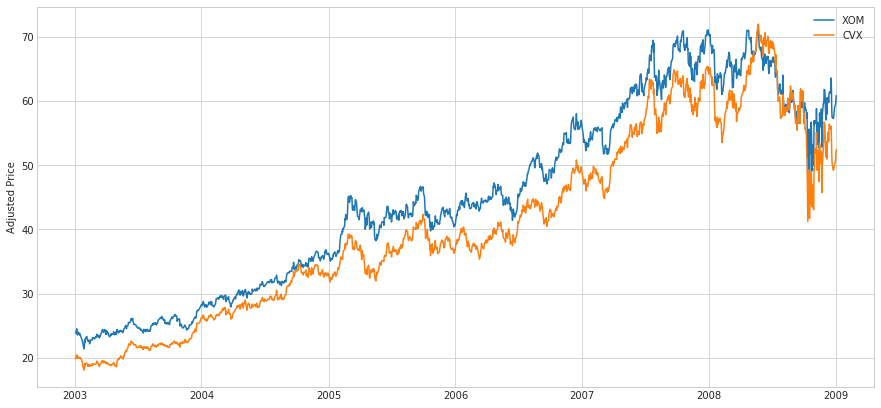

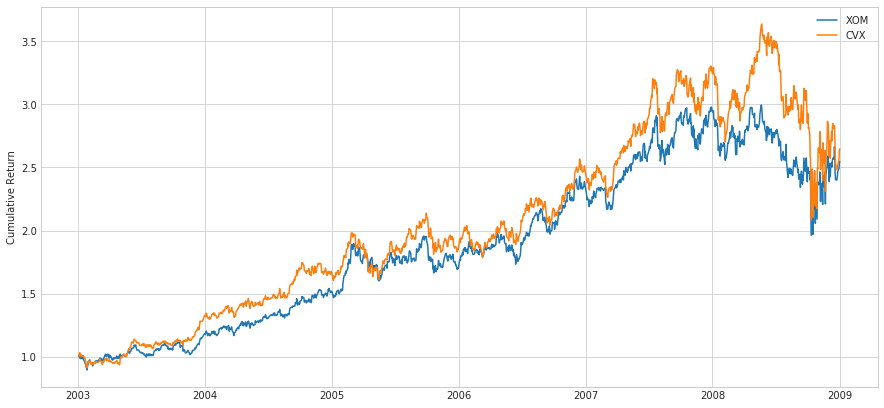

In [4]:
symbols = ["XOM","CVX"]
data = {}
plt.figure(figsize =(15,7))
for syl in symbols:
    qb.AddEquity(syl)
    data[syl] = qb.History([syl], datetime(2003,1,1), datetime(2009,1,1), Resolution.Daily).loc[syl]['close']
    data[syl].index = data[syl].index.date
    data[syl].plot(label=syl)
plt.legend()
plt.ylabel('Adjusted Price')
plt.figure(figsize =(15,7))
for syl in symbols:    
    (1+data[syl].pct_change()).cumprod().plot(label=syl)
plt.legend()
plt.ylabel('Cumulative Return')

We choose stock A :XOM, stock B:CVX. From the above plot, we can see two series are highly correlated with each other. Next, we will explore this relationship further.

### Step 2: Estimate Spreads
If we have two stocks, X and Y, which are cointegrated in their price movements, then any divergence in the spread from 0 should be temporary and mean-reverting. Next step we will estimate the spread series.

In [5]:
# Run linear regression over two log price series
x = list(np.log(data[symbols[0]]))
x_const = sm.add_constant(x)
y = list(np.log(data[symbols[1]]))
linear_reg = sm.OLS(y,x_const)
results = linear_reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 8.480e+04
Date:                Fri, 23 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:53:58   Log-Likelihood:                 2425.7
No. Observations:                1511   AIC:                            -4847.
Df Residuals:                    1509   BIC:                            -4837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3106      0.014    -22.778      0.000      -0.337      -0.284
x1             1.0541      0.004    291.206      0.000       1.047       1.061
==============================================================================
Omnibus:                       45.283   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.035
Skew:                           0.412   Prob(JB):                     6.12e-11
Kurtosis:                       2.740   Cond. No.                         43.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
beta = results.params[1]
alpha = results.params[0]

In [7]:
y_pred = np.log(data[symbols[0]])*beta + alpha

Text(0,0.5,'CVX')

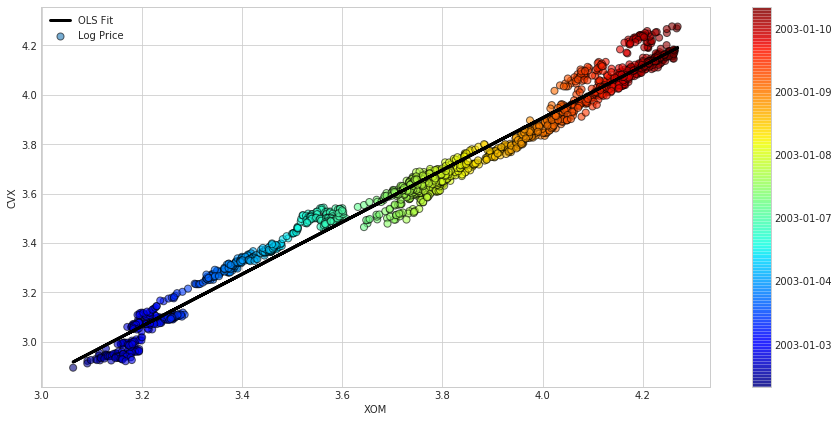

In [8]:
plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(np.log(data[symbols[0]]), np.log(data[symbols[1]]), s=50, c=x, cmap=cm, marker='o',
                 alpha=0.6,label='Log Price',edgecolor='k')
plt.plot(x, y_pred, '-',c='black',linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in data[symbols[0]].index])
plt.xlabel(symbols[0])
plt.ylabel(symbols[1])

Text(0,0.5,'spread')

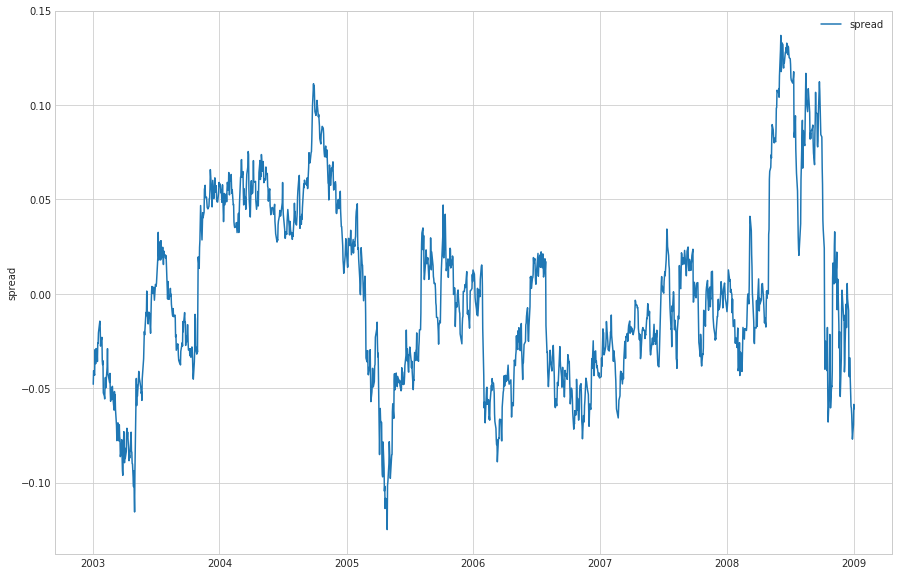

In [9]:
# construct the spread series according to OLS result
df = pd.DataFrame(np.log(data[symbols[1]]) - np.log(data[symbols[0]])*beta-alpha,index=data[symbols[0]].index)
df.columns = ['spread']
df.plot(figsize =(15,10))
plt.ylabel('spread')

### Step 3: Check Stationarity
From the above plot, the first order difference $Spread_t=log(y_t) -\beta log(x_t)-\alpha$ seems to be stationary and mean-reversion. Next, we will check if it is stationary.


In [12]:
# check if the spread is stationary 
adf = sm.tsa.stattools.adfuller(df['spread'], maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

ADF test statistic: -3.45
	1%: -3.435
	5%: -2.863
	10%: -2.568
p-value: 0.009


Running the example prints the test statistic value of -3.45. The more negative this statistic, the more likely we are to reject the null hypothesis (there is a unit root).

As part of the output, we get a table to help determine the ADF statistic. We can see that our statistic value of -3.45 is less than the value of -3.435 at 1%. The p-value 0.009 is less than 0.05.

This suggests that we can reject the null hypothesis with a significance level of less than 1%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

### Step 4: Create Trading Signal
Here we use 1.96 times the standard deviation as our threshold. 1.96 is the approximate value of the 97.5 percentile point of the normal distribution. 95% of the area under a normal curve lies within roughly 1.96 standard deviations of the mean. If the sample is out of this range, then we think there is a price divergence between these two stocks price which means the pairs trading opportunity.

In [13]:
df['mean'] = df['spread'].mean()
df['upper'] = df['mean'] + 1.96*df['spread'].std()
df['lower'] = df['mean'] - 1.96*df['spread'].std()

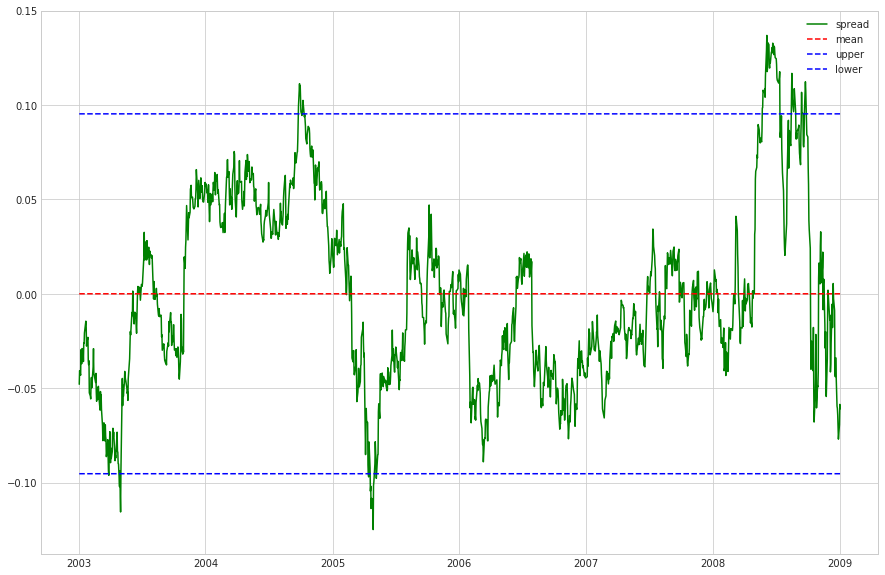

In [14]:
df.plot(figsize =(15,10),style=['g', '--r', '--b', '--b'])

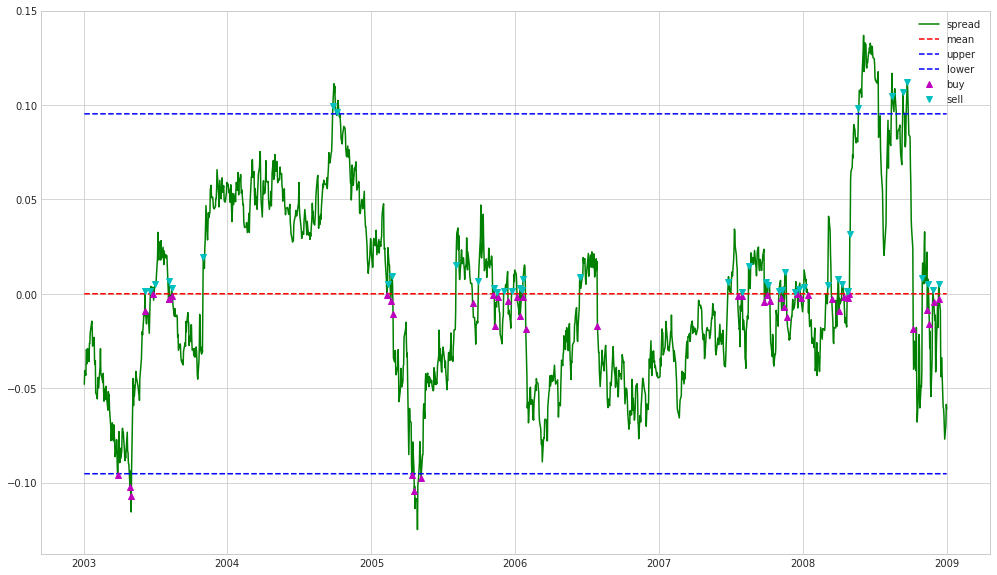

In [15]:
df['buy'] = df['spread'][((df['spread'] < df['lower']) & (df['spread'].shift(1) > df['lower']) | 
                          (df['spread'] <  df['mean']) & (df['spread'].shift(1) >  df['mean']))]

df['sell'] = df['spread'][((df['spread'] > df['upper']) & (df['spread'].shift(1) < df['upper']) | 
                           (df['spread'] >  df['mean']) & (df['spread'].shift(1) <  df['mean']))]
df.plot(figsize =(17,10), style=['g', '--r', '--b', '--b', 'm^','cv'])

Here buying the spread means buy 1 unit of stock B(CVX) and sell $\beta$ units of stock A(XOM). We expect that the relationship between x and y will hold in the future. Buying the spread when it is lower than the standard deviation $\sigma $ and closing out the position when it returns to mean $\mu$. Selling the spread means to sell 1 unit of stock B(CVX) and buy $\beta$ units of stock A(XOM) and when it is above $\sigma$ and close the position when reaching the long-term mean to realize a profit.

## Method: Kalman Filter 

If we use linear regression to estimate those two parameters for the spread calculation, the main issue is that we have to pick an arbitrary lookback window and assume in the near future they will still keep this relationship and the spread will convergence to its long-term equilibrium. But in practice, $\alpha$ and $\beta$ are not constants and vary over time. They are not market observables. On the other hand, the long-term relationship can break down.

In the following research, we use Kalman filter to model the spread. This is an adaptive filter which updates itself iteratively and produces $\alpha$, $\beta$ dynamically. We use the python package pykalman which has the EM method that calibrates the covariance matrices over the training period.

For the model details 
https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter

In [16]:
obs_mat = sm.add_constant(np.log(data[symbols[0]]).values, prepend=False)[:, np.newaxis]
trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)

In [18]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=0.5,
                  transition_covariance=0.000001 * np.eye(2))

Text(0,0.5,'intercept')

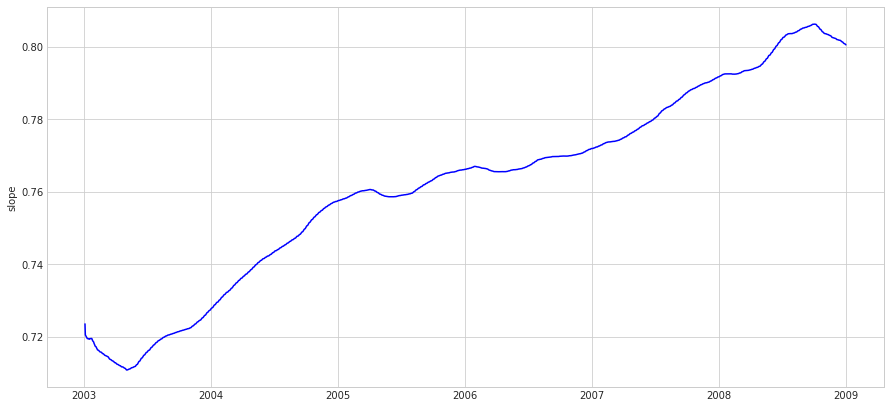

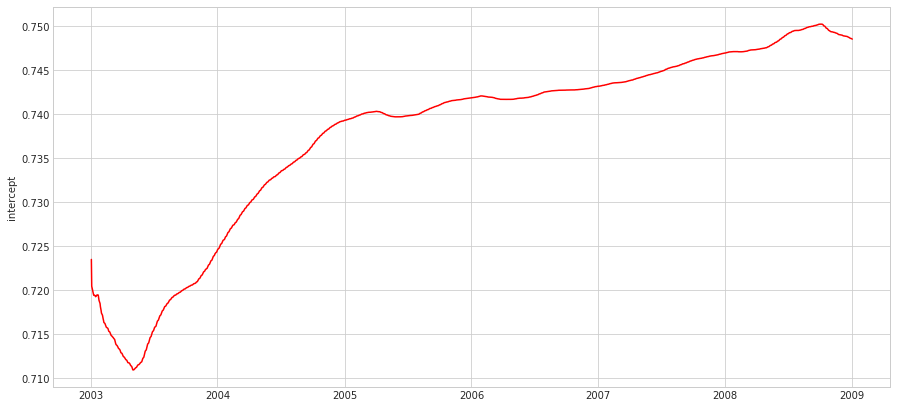

In [19]:
state_means, state_covs = kf.filter(np.log(data[symbols[1]]).values)
slope=state_means[:, 0] 
intercept=state_means[:, 1]
plt.figure(figsize =(15,7))
plt.plot(data[symbols[1]].index, slope, c='b')
plt.ylabel('slope')
plt.figure(figsize =(15,7))
plt.plot(data[symbols[1]].index,intercept,c='r')
plt.ylabel('intercept')

From the result above, the slope increases and the intercept doesn't change too much as the time goes.

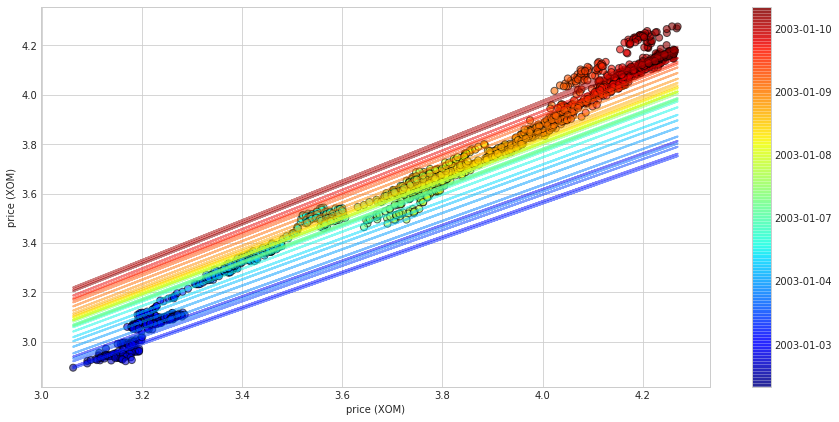

In [20]:
# visualize the correlation between assest prices over time
plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(np.log(data[symbols[0]]), np.log(data[symbols[1]]), s=50, c=x, cmap=cm, marker='o',
                 alpha=0.6,label='Price',edgecolor='k')
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in data[symbols[0]].index])
plt.xlabel("price (%s)" %symbols[0])
plt.ylabel("price (%s)" %symbols[0])

# add regression lines
step = 50 # pick slope and intercept every 50 days
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, b in enumerate(state_means[::step]):
    plt.plot(np.log(data[symbols[0]]), b[0] *np.log(data[symbols[0]]) + b[1], alpha=.5, lw=2, c=cm(colors_l[i]))

Next we plot the original spread and the spread estimated using Kalman Filter.

In [21]:
kl_spread = np.log(data[symbols[1]]) - np.log(data[symbols[0]]) * state_means[:,0] - state_means[:,1]
df['kl_spread'] = kl_spread

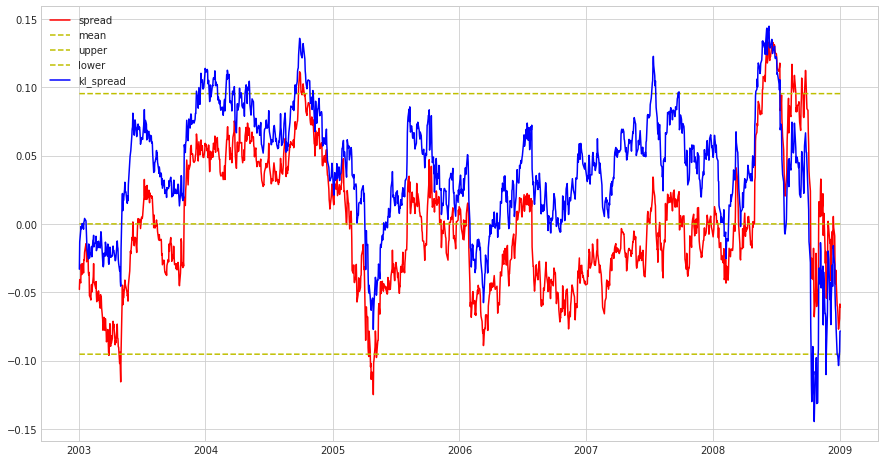

In [22]:
new_df = df.drop(['buy','sell'],1)
new_df.plot(figsize =(15,8),style=['r','--y', '--y', '--y','b'])

Reference:
   https://www.quantopian.com/posts/582de686358fe9440b0007f2#587e9dae9ea10879ef9ecb16
    
https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter